In [1]:
%pip install "git+https://github.com/jsbrittain/saccadapt.git#subdirectory=eye"
import eye as Eye
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from typing import List
matplotlib.use('nbagg')

%matplotlib inline

  Cloning https://github.com/jsbrittain/saccadapt.git to /tmp/pip-req-build-noq4mk80
  Running command git clone --filter=blob:none --quiet https://github.com/jsbrittain/saccadapt.git /tmp/pip-req-build-noq4mk80
  Resolved https://github.com/jsbrittain/saccadapt.git to commit 595a1f5b2e314eb861c8cc7287513351028a9b50
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for eye: filename=eye-0.1.0-py3-none-any.whl size=4032 sha256=17a700f921090b041d8eff9cf8de26e8cbd44ce73974d65cd19f4ede654e6e74
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lx5i_0p/wheels/9e/c3/b9/73ffd62f0351151da04a178477d4ac9d85ead39e97c8d5228e
Successfully built eye


## Mount Google Drive then load eyelink data

Remove this section if you are uploading files manually.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

filename = "drive/MyDrive/sacc.adapt.data/asc/EW_200.asc"

eye = Eye.Eye(filename)

Mounted at /content/drive


### Examine channel data

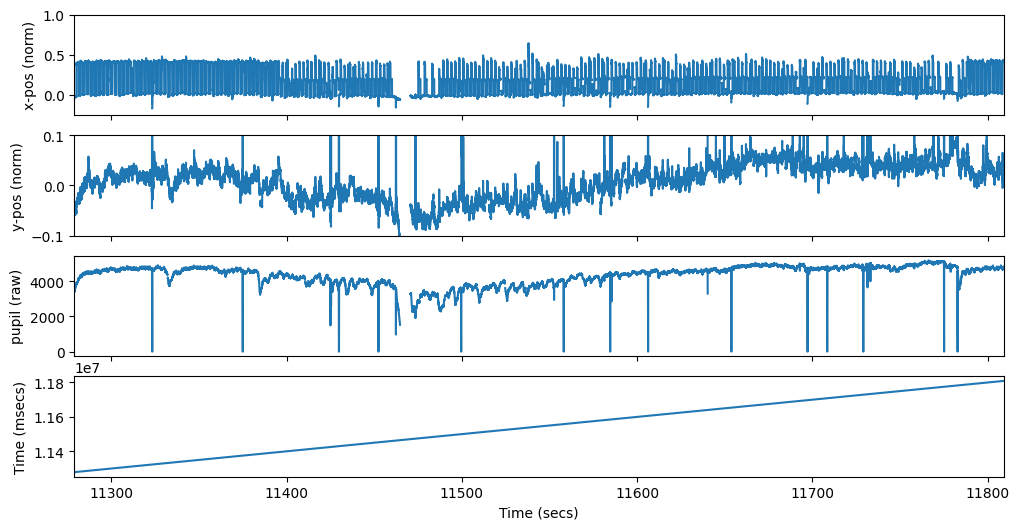

In [4]:
time_secs = eye.data['Time (msecs)']/1000
fig, axs = plt.subplots(len(eye.data.columns), figsize=(12, 6), sharex=True)
for k, colname in enumerate(eye.data.columns):
    axs[k].plot(time_secs, eye.data[colname])
    axs[k].set_ylabel(colname)
axs[0].set_xlim(time_secs.iloc[0], time_secs.iloc[-1])

axs[0].set_ylim(-0.25, 1.0)
axs[1].set_ylim(-0.1, 0.1)
# axs[2].set_ylim(600, 2000)
axs[3].set_xlabel('Time (secs)')
fig.show()

### xy-trace

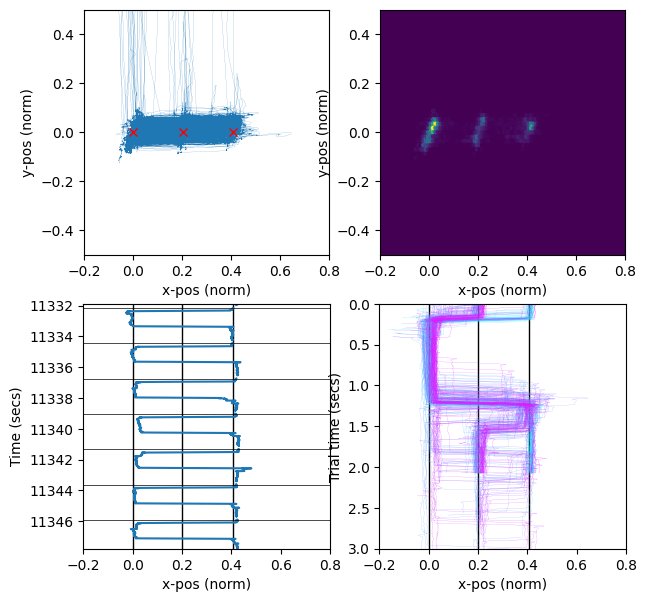

In [5]:
chx, chy = 'x-pos (norm)', 'y-pos (norm)'  # x, y

fig, axs = plt.subplot_mosaic(
    [['b','c'], ['a','d']],
    figsize=(7, 7),
)

# temporal segment
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['a'].plot(np.array([x, x]), [time_secs.iloc[0], time_secs.iloc[-1]], 'k-', linewidth=1)
axs['a'].plot(eye.data[chx], time_secs)
for start, end in zip(eye.trial.StartPos, eye.trial.EndPos):
  axs['a'].plot(np.array([-1, 1]), np.array([start, start])/eye._SAMPLE_RATE, 'k-', linewidth=0.5)
axs['a'].set_xlim(-0.2, 0.8)
axs['a'].set_xlabel(chx)
axs['a'].set_ylabel('Time (secs)')
axs['a'].set_ylim(
    time_secs.iloc[round(0.100*len(time_secs))],
    time_secs.iloc[round(0.130*len(time_secs))],
)
axs['a'].invert_yaxis()

# xy-trace
axs['b'].plot(eye.data[chx], eye.data[chy], linewidth=0.1)
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['b'].plot(x, y, 'rx')
axs['b'].set_aspect('equal', 'box')
axs['b'].set_xlim(-0.2, 0.8)
axs['b'].set_ylim(-0.5, 0.5)
axs['b'].set_xlabel(chx)
axs['b'].set_ylabel(chy)

# spatial histogram
axs['c'].hexbin(
    eye.data[chx],
    eye.data[chy],
    extent=(-0.2, 0.8, -0.5, 0.5),
)
axs['c'].set_aspect('equal', 'box')
axs['c'].set_xlim(-0.2, 0.8)
axs['c'].set_ylim(-0.5, 0.5)
axs['c'].set_xlabel(chx)
axs['c'].set_ylabel(chy)

# stack trials
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['d'].plot(np.array([x, x]), np.array([0.0, 3.0]), 'k-', linewidth=1)
viridis = matplotlib.colormaps['cool']
for index, (start, end) in enumerate(zip(eye.trial.StartPos, eye.trial.EndPos)):
  axs['d'].plot(
      eye.data[chx].loc[start:end],
      time_secs.loc[start:end]-time_secs.loc[start],
      '-',
      linewidth=0.1,
      color=viridis(index/(len(eye.trial)-1)),
  )
axs['d'].set_ylabel('Trial time (secs)')
axs['d'].set_xlabel(chx)
axs['d'].set_xlim(-0.2, 0.8)
axs['d'].set_ylim(0, 3)
axs['d'].invert_yaxis()

fig.show()

## Extract per-trial metrics

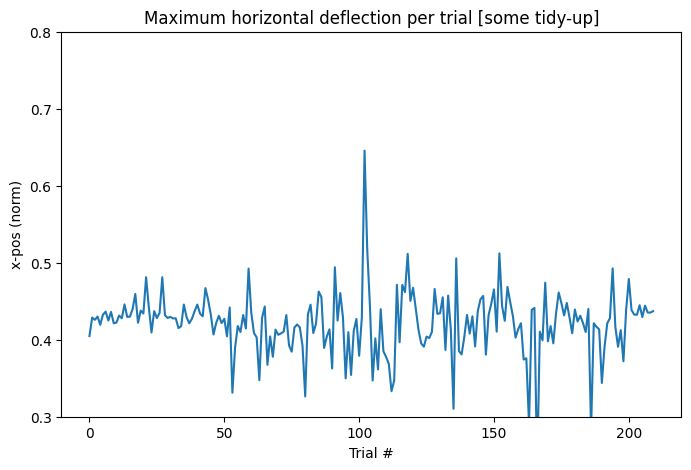

In [6]:
# Loop over trials
eye.trial['max_x'] = [0]*len(eye.trial)
for index, (start, end) in enumerate(zip(eye.trial.StartPos, eye.trial.EndPos)):
  eye.trial['max_x'].at[index] = max(eye.data[chx].loc[start:end])

# Plot metric
data = eye.trial['max_x']
data[data>0.8] = None  # Remove obvious outliers (for now)

fig, axs = plt.subplots(1, figsize=(8, 5), sharex=True)
axs.plot(data)
axs.set_ylim([0.3, 0.8])
axs.set_ylabel(chx)
axs.set_xlabel("Trial #")
axs.set_title("Maximum horizontal deflection per trial [some tidy-up]")

fig.show()

[ 960 1153 1349]


Text(0.5, 1.0, 'Inward target delay relative to start of saccade (median=205.0 msecs)')

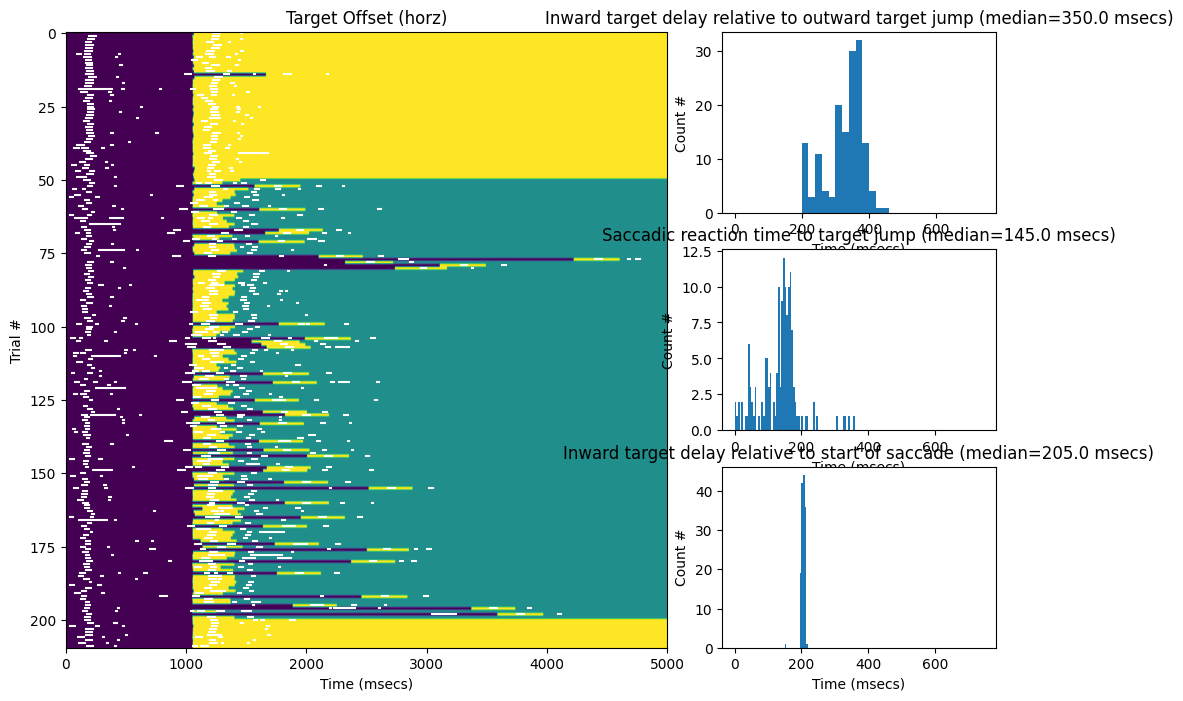

In [91]:
# Auto-determine target locations
# alternatively, try target_positions = [960, 1349, 1153]
target_positions = [t[1][0] for index in eye.trial.index for t in eye.trial['Targets'].loc[index]]
target_positions = np.sort(np.unique(target_positions))
print(target_positions)

# Loop over trials
fig, axs = plt.subplot_mosaic(
    [['a','a','b'], ['a','a','c'], ['a','a','d']],
    figsize=(12, 8),
)
count = 0
max_samples = 5000
x = 960 * np.ones((len(eye.trial), max_samples))
x_mean = np.zeros(max_samples)
inward_delay = []
sacc_delay = []
sacc_rt = []
for index in eye.trial.index:
  targets = eye.trial['Targets'].loc[index]
  last_target_time = 0
  outward_time, inward_time = 0, 0
  for t in targets:
    target_time, target_pos = int(t[0]-eye.trial['StartPos'].loc[index]), t[1]
    assert target_time > last_target_time
    last_target_time = target_time
    x[index, target_time:] = target_pos[0]
    if target_pos[0] == target_positions[2]:
      outward_time = target_time
    if target_pos[0] == target_positions[1]:
      inward_time = target_time
      assert inward_time > outward_time
      inward_delay.append(target_time - outward_time)
  # First saccade after outward_time
  saccades = eye.trial['Saccades'].loc[index]
  if inward_time > 0 and outward_time > 0:
    for sacc in saccades:
      sacc_time = sacc[0] - eye.trial['StartPos'].loc[index]
      if sacc_time > outward_time:
        sacc_delay.append(inward_time - sacc_time)
        sacc_rt.append(sacc_time - outward_time)
        break

offset = 0.0
plot_saccades = True
plot_fixations = False

axs['a'].imshow(x, aspect='auto')
for index in eye.trial.index:
  if plot_saccades:
    saccades = eye.trial['Saccades'].loc[index]
    for sacc in saccades:
      axs['a'].plot([
          sacc[0] - eye.trial.StartPos.loc[index],
          sacc[1] - eye.trial.StartPos.loc[index]],
          [index - offset, index - offset], 'w-')
  if plot_fixations:
    fixations = eye.trial['Fixations'].loc[index]
    for fix in fixations:
      axs['a'].plot([
          fix[0] - eye.trial.StartPos.loc[index],
          fix[1] - eye.trial.StartPos.loc[index]],
          [index + offset, index + offset], 'r-')
axs['a'].set_xlim(0, 5000)
axs['a'].set_xlabel('Time (msecs)')
axs['a'].set_ylabel('Trial #')
axs['a'].set_title("Target Offset (horz)")

axs['b'].hist(inward_delay, range(0, 750, 20))
axs['b'].set_xlabel('Time (msecs)')
axs['b'].set_ylabel('Count #')
axs['b'].set_title(f"Inward target delay relative to outward target jump (median={np.median(inward_delay)} msecs)")

axs['c'].hist(sacc_rt, range(0, 750, 5))
axs['c'].set_xlabel('Time (msecs)')
axs['c'].set_ylabel('Count #')
axs['c'].set_title(f"Saccadic reaction time to target jump (median={np.median(sacc_rt)} msecs)")

axs['d'].hist(sacc_delay, range(0, 750, 5))
axs['d'].set_xlabel('Time (msecs)')
axs['d'].set_ylabel('Count #')
axs['d'].set_title(f"Inward target delay relative to start of saccade (median={np.median(sacc_delay)} msecs)")